In [1]:

import gc
import os
import torch
import random   

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from copy import copy
from tqdm import tqdm
from torch.optim import Adam, SGD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss,mean_squared_error


### Load Data

In [2]:
## https://github.com/JeffSackmann/tennis_wta

DATA_PATH = 'D://Medium'
os.listdir(DATA_PATH)

def load_data():
    return pd.read_csv(os.path.join(DATA_PATH, 'ncaam_sample_data.csv'))

data = load_data()
data.head()


,season,team_score,opp_score,is_home,numot,team_fgm,team_fga,team_fgm3,team_fga3,team_ftm,...,opp_or,opp_dr,opp_ast,opp_to,opp_stl,opp_blk,opp_pf,team_name,opp_name,date
0,2003,68,62,0,0,27,58,3,14,11,...,10,22,8,18,9,2,20,Alabama,Oklahoma,2002-11-14
1,2003,70,63,0,0,26,62,8,20,10,...,20,25,7,12,8,6,16,Memphis,Syracuse,2002-11-14
2,2003,62,68,0,0,22,53,2,10,16,...,14,24,13,23,7,1,22,Oklahoma,Alabama,2002-11-14
3,2003,63,70,0,0,24,67,6,24,9,...,15,28,16,13,4,4,18,Syracuse,Memphis,2002-11-14
4,2003,55,81,-1,0,20,46,3,11,12,...,12,24,12,9,9,3,18,E Washington,Wisconsin,2002-11-15


In [3]:



list(data)




['season',
 'team_score',
 'opp_score',
 'is_home',
 'numot',
 'team_fgm',
 'team_fga',
 'team_fgm3',
 'team_fga3',
 'team_ftm',
 'team_fta',
 'team_or',
 'team_dr',
 'team_ast',
 'team_to',
 'team_stl',
 'team_blk',
 'team_pf',
 'opp_fgm',
 'opp_fga',
 'opp_fgm3',
 'opp_fga3',
 'opp_ftm',
 'opp_fta',
 'opp_or',
 'opp_dr',
 'opp_ast',
 'opp_to',
 'opp_stl',
 'opp_blk',
 'opp_pf',
 'team_name',
 'opp_name',
 'date']

In [4]:

raw_stats = ['score','fgm','fga','fgm3','fga3','ftm','fta','or','dr','ast','to','stl','blk','pf']
def feature_eng(df):
    
    df['date'] = pd.to_datetime(df['date'].copy())
    df = df.sort_values(by='date').reset_index(drop=True)
    
    df['team_game_of_season'] = df.groupby(['season','team_name'])['team_score'].transform('cumcount')/38 # scale for NN
    df['opp_game_of_season'] = df.groupby(['season','opp_name'])['opp_score'].transform('cumcount')/38 # scale for NN

    ## need match id. And going to only do one row per game, shuffled between perspective of winner and loser
    df['team_A'] = df[['team_name','opp_name']].copy().apply(lambda x: sorted([x.team_name, x.opp_name])[0],axis=1)
    df['match_id'] = df['date'].copy().astype(str)+'_'+df['team_A'].copy()
    df = df.sample(frac=1)
    df = df.drop_duplicates(subset=['match_id'], keep='first')
    df = df.drop('team_A',axis=1)
    df = df.sort_values(by='date').reset_index(drop=True)
    
    targets = ['score_diff','reb_diff','score_total']
    stats = ['score_total','game_poss', 'reb_diff']
    for raw_stat in raw_stats:
        df[f'{raw_stat}_diff'] = df[f'team_{raw_stat}'].copy()-df[f'opp_{raw_stat}'].copy()
        stats.append(f'{raw_stat}_diff')
    meta = ['is_home','days_rest', 'opp_days_rest','team_game_of_season','opp_game_of_season']
    
    ## For NN, will have to scale
    ## meta first
    df['last_played'] = df.groupby(['team_name'])['date'].transform('shift')
    df['last_played'] = df['last_played'].fillna(df['date'].copy()-pd.Timedelta(days=42))
    df['opp_last_played'] = df.groupby(['opp_name'])['date'].transform('shift')
    df['opp_last_played'] = df['opp_last_played'].fillna(df['date'].copy()-pd.Timedelta(days=42))
    df['days_rest'] = ((df['date'].copy()-df['last_played'].copy()).dt.days)/365
    df['opp_days_rest'] = ((df['date'].copy()-df['opp_last_played'].copy()).dt.days)/365
    df = df.drop(columns=['last_played','opp_last_played'])
    
    ## other raw stats already created 
    df['game_poss'] = (df['team_fga'].copy()+df['opp_fga'].copy()+0.44*df['team_fta'].copy()+0.44*df['opp_fta'].copy()-df['team_or'].copy()-df['opp_or'].copy()+df['team_to'].copy()+df['opp_to'].copy())/2
    df['team_reb'] = df['team_or'].copy()+df['team_dr'].copy()
    df['opp_reb'] = df['opp_or'].copy()+df['opp_dr'].copy()
    df['reb_diff'] = df['team_reb'].copy()-df['opp_reb'].copy()
    df['score_total'] = df['team_score'].copy()+df['opp_score'].copy()
    
    df['result'] = np.where(df['team_score'].copy()>df['opp_score'].copy(), 1, 0)
    
    return df, targets, stats, meta

data, targets, stats, meta = feature_eng(data)


In [5]:

opp_transform = np.array([1,1]+list(-1*np.ones(15)))


In [6]:

teams = set(data['team_name'].unique()).union(set(data['opp_name'].unique()))


In [7]:

print(list(data))
data.head()


['season', 'team_score', 'opp_score', 'is_home', 'numot', 'team_fgm', 'team_fga', 'team_fgm3', 'team_fga3', 'team_ftm', 'team_fta', 'team_or', 'team_dr', 'team_ast', 'team_to', 'team_stl', 'team_blk', 'team_pf', 'opp_fgm', 'opp_fga', 'opp_fgm3', 'opp_fga3', 'opp_ftm', 'opp_fta', 'opp_or', 'opp_dr', 'opp_ast', 'opp_to', 'opp_stl', 'opp_blk', 'opp_pf', 'team_name', 'opp_name', 'date', 'team_game_of_season', 'opp_game_of_season', 'match_id', 'score_diff', 'fgm_diff', 'fga_diff', 'fgm3_diff', 'fga3_diff', 'ftm_diff', 'fta_diff', 'or_diff', 'dr_diff', 'ast_diff', 'to_diff', 'stl_diff', 'blk_diff', 'pf_diff', 'days_rest', 'opp_days_rest', 'game_poss', 'team_reb', 'opp_reb', 'reb_diff', 'score_total', 'result']


,season,team_score,opp_score,is_home,numot,team_fgm,team_fga,team_fgm3,team_fga3,team_ftm,...,blk_diff,pf_diff,days_rest,opp_days_rest,game_poss,team_reb,opp_reb,reb_diff,score_total,result
0,2003,68,62,0,0,27,58,3,14,11,...,-1,2,0.115068,0.115068,72.80,38,32,6,130,1
1,2003,70,63,0,0,26,62,8,20,10,...,-2,2,0.115068,0.115068,68.08,43,45,-2,133,1
2,2003,55,81,-1,0,20,46,3,11,12,...,0,7,0.115068,0.115068,66.18,28,36,-8,136,0
3,2003,77,71,0,0,30,61,6,14,11,...,3,6,0.115068,0.115068,63.30,39,36,3,148,1
4,2003,61,73,0,0,22,73,3,26,14,...,3,-2,0.115068,0.115068,63.94,53,43,10,134,0


### Run Classic Elo

In [8]:

class StatefulSystem:
    def __init__(self):
        self.history = []  # to store history of predictions and results

    def predict_1v1(self, player1, player2, **kwargs):
        raise NotImplementedError  # This method should be implemented in child classes

    def update_1v1(self, player1, player2, result, **kwargs):
        raise NotImplementedError  # This method should be implemented in child classes
        
class PlayerNode():
    def __init__(self, rating):
        self.rating=rating
        
class EloNode(PlayerNode):
    def __init__(self,_id, name, rating=1500):
        super().__init__(rating)
        self._id = _id
        self.name = name
        self.rating = rating
        self.rank = 200
        
class EloSystem(StatefulSystem):
    def __init__(self, k_factor, meta_functions=None):
        super().__init__()
        self.history = []
        self.k_factor = k_factor
        ## for edge info like home, days off
        self.meta_functions = meta_functions

    def predict_1v1(self, player1, player2, **kwargs):
        # Meta information can be accessed as dictionary items, e.g., kwargs['is_home'], kwargs['days_off']
        rd = player1.rating - player2.rating
        if self.meta_functions is not None:
            ## add all adjustments for meta information
            for meta_key, meta_function in self.meta_functions.items():
                rd += meta_function(kwargs[meta_key])
        prediction = 1/(1+10**(-rd/400))
        return prediction
    def update_1v1(self, prediction, result):
        points_exchanged = self.k_factor*(result-prediction)
        return points_exchanged
    
    def play_match(self, p1, p2, result, update_both=False, **kwargs):
        prediction = self.predict_1v1(p1, p2, **kwargs)
        ratings_delta = self.update_1v1(prediction, result)
        self.history.append([p1._id, p1.name, p2._id, p2.name, p1.rating, p2.rating, prediction, result, ratings_delta])
        p1.rating+=ratings_delta
        if update_both:
            p2.rating-=ratings_delta
        return p1, p2
    
    def get_history(self):
        return pd.DataFrame(self.history, columns=['p1_id','p1_name','p2_id','p2_name','p1_rating','p2_rating','prediction','result','ratings_delta'])

elo_sys = EloSystem(k_factor=40)
# player_ratings = {_id:EloNode(_id, name, 1500) for _id, name in player_names.items()}
team_ratings = {name:EloNode(i, name, 1500) for i, name in enumerate(teams)}
for index, row in tqdm(data.iterrows(), total=len(data)):
    
    t1 = row['team_name']
    t2 = row['opp_name']
    
    t1_node = team_ratings[t1]
    t2_node = team_ratings[t2]
    
    result = 1 if (row['team_score']-row['opp_score'])>0 else 0

    t1_node, t2_node = elo_sys.play_match(t1_node, t2_node, result, update_both=True)
    
    team_ratings[t1] = t1_node
    team_ratings[t2] = t2_node
    
    
hist = elo_sys.get_history()
hist
    

100%|███████████████████████████████████████████████████████████████████████| 103280/103280 [00:02<00:00, 41604.70it/s]


,p1_id,p1_name,p2_id,p2_name,p1_rating,p2_rating,prediction,result,ratings_delta
0,148,Alabama,70,Oklahoma,1500.000000,1500.000000,0.500000,1,20.000000
1,177,Memphis,251,Syracuse,1500.000000,1500.000000,0.500000,1,20.000000
2,38,E Washington,97,Wisconsin,1500.000000,1500.000000,0.500000,0,-20.000000
3,191,Texas,141,Georgia,1500.000000,1500.000000,0.500000,1,20.000000
4,302,Villanova,52,Marquette,1500.000000,1500.000000,0.500000,0,-20.000000
...,...,...,...,...,...,...,...,...,...
103275,261,North Carolina,132,St Peter's,2047.468070,1620.746851,0.921029,1,3.158858
103276,27,Miami FL,288,Kansas,1959.018606,2155.153018,0.244338,0,-9.773529
103277,302,Villanova,288,Kansas,2157.342296,2164.926547,0.489087,0,-19.563485
103278,207,Duke,261,North Carolina,2096.882959,2050.626928,0.566177,0,-22.647090


In [9]:
from sklearn.metrics import log_loss
## 20: 0.5717748620218386
## 30: 0.5688727434688168
## 40: 0.5684751964171788
## 45: 0.5694965390004977
## 60: 0.5735
grade_cutoff = int(0.2*len(hist))
log_loss(hist[-grade_cutoff:]['result'].values, hist[-grade_cutoff:]['prediction'].values)

0.568873429972994

In [10]:

rtg_df = pd.DataFrame([[k,v.name, v.rating] for k,v in team_ratings.items()], columns=['id','name','rating'])
rtg_df.sort_values(by='rating', ascending=False).head(20)


,id,name,rating
288,Kansas,Kansas,2198.297987
219,Gonzaga,Gonzaga,2182.581492
302,Villanova,Villanova,2137.778811
328,Baylor,Baylor,2127.109214
21,Houston,Houston,2082.292836
207,Duke,Duke,2074.235869
128,Arizona,Arizona,2061.981370
261,North Carolina,North Carolina,2059.466062
280,Tennessee,Tennessee,2042.358774
158,Arkansas,Arkansas,2038.398964


### Create Pytorch Elo Classes


In [37]:

# One neuron to learn scaling and a sigmoid activation function.
class EloPredictNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=False)  # No bias so that ratings delta of 0 = 50% win prob

    def forward(self, rd):
        return torch.sigmoid(self.linear(rd))
    
class EloUpdateNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=False)  # No bias so that matches are symmetrical (no advantage to being player A)
        
    def forward(self, pred_error):
        return self.linear(pred_error)
    
class NetworkNode(PlayerNode):
    def __init__(self,_id, name, rating=0):
        super().__init__(rating)
        self._id = _id
        self.name = name
        self.rating = rating
        self.last_rating = rating
        self.last_error = 0.5



### Let's try learning the weights

In [12]:

## split into train/test
percent_30 = int(0.3*len(data))
train = data.copy()[:-percent_30]
test = data.copy()[-percent_30:]


In [13]:

predict_model = EloPredictNN()
predict_optimizer = Adam(predict_model.parameters(), lr=1e-6)

update_model = EloUpdateNN()
update_optimizer = Adam(update_model.parameters(), lr=1e-6)

batch_size = 24 
num_batches = len(train)//batch_size
num_epochs = 2
best_val_loss = np.inf



In [14]:

## temporal component important so no shuffle
for j in range(num_epochs):
    network_team_ratings = {name:NetworkNode(i, name, 0) for i, name in enumerate(teams)}
    epoch_loss = []
    predict_model.train()
    update_model.train()
    for i in tqdm(range(num_batches-1), total=num_batches-1):
        predict_optimizer.zero_grad()
        update_optimizer.zero_grad()
        train_data = train[i*batch_size:(i+1)*batch_size].copy()

        results = torch.from_numpy(train_data.result.copy().astype('float32').values).view(-1,1)
        
        t1_nodes = [network_team_ratings[k] for k in train_data.team_name.values]
        t2_nodes = [network_team_ratings[k] for k in train_data.opp_name.values]
        
        predict_X = torch.Tensor([t2_nodes[k].rating-t1_nodes[k].rating for k in range(len(t1_nodes))]).view(-1,1)
        
        ## I found that only updating one model at a time seems to give more stable results
        ## worth investigating further
        update_or_predict = np.random.random()
        
        if update_or_predict>0.5:
            ## PREDICT MODEL (easy part)
            ## have to make it symmetrical (p2_rating-p1_rating and p1_rating-p2_rating)
            predictions = predict_model(predict_X)
            
            predict_loss = nn.BCELoss()(predictions, results)
            predict_loss.backward()

            # Update the model's parameters
            ## for the first few iterations, let ratings stabilize
            if (j>0)&(i < 20):
                continue
            elif (j>1)&(i < 100):
                continue
            else:
                predict_optimizer.step()
            # Zero the gradients since PyTorch accumulates them
            predict_optimizer.zero_grad()
        
        else:
            ## UPDATE MODEL (slightly harder)
            ## use previous game's results to calculate loss of the update model
            predictions = predict_model(predict_X)
            predict_optimizer.zero_grad()
            
            ## directionality is important here, last error is simply result - prediction (is negative if the player loses)
            t1_update_X = torch.Tensor([t1_node.last_error for t1_node in t1_nodes]).view(-1,1)
            t2_update_X = torch.Tensor([t2_node.last_error for t2_node in t2_nodes]).view(-1,1)

            t1_update_predictions = update_model(t1_update_X)
            t2_update_predictions = update_model(t2_update_X)

            ## want both baseline predict model (no update) and predict model with updates. Compare to create loss
            baseline_X = torch.Tensor([t2_nodes[k].last_rating-t1_nodes[k].last_rating for k in range(len(t1_nodes))]).view(-1,1)
            update_model_X = torch.Tensor([t2_nodes[k].last_rating+t2_update_predictions[k] - t1_nodes[k].last_rating+t1_update_predictions[k] for k in range(len(t1_nodes))]).view(-1,1)

            baseline_predictions = predict_model(baseline_X)
            update_model_predictions = predict_model(update_model_X)
            baseline_BCE = nn.BCELoss()(baseline_predictions, results)
            update_model_BCE = nn.BCELoss()(update_model_predictions, results)
            ## lower is better, has to be negative if improving ratings
            update_loss = update_model_BCE-baseline_BCE
            update_loss.backward()
            ## skip the first few iterations of the later epochs to give some time for ratings to develop
            if (j>0)&(i < 25):
                continue
            elif (j>1)&(i < 100):
                continue
            else:
                update_optimizer.step()
            update_optimizer.zero_grad()
        
        ## now just update the nodes with the predictions
        ## in Elo this step is k*(result-predictions)
        ## we are finding k
        pred_error = results - predictions
        epoch_loss.extend(list(pred_error[:,0].detach().numpy()))
        updates = update_model(pred_error)
        new_ratings = [t1_nodes[k].rating+updates[k] for k in range(len(t1_nodes))]

        for l, team_node in enumerate(t1_nodes):
            team_node.last_rating = copy(team_node.rating)
            team_node.last_error = pred_error[l, 0]
            team_node.rating = float(new_ratings[l])
            network_team_ratings[team_node._id] = copy(team_node)
            
    ## calculate val
    predict_model.eval()
    update_model.eval()
    
    network_team_ratings = {name:NetworkNode(_id, name, 0) for _id, name in enumerate(teams)}

    nn_history = []
    for index, row in tqdm(data.iterrows(), total=len(data)):
        
        t1_id, t2_id = row['team_name'], row['opp_name']
        
        t1_nn_node = network_team_ratings[t1_id]
        t2_nn_node = network_team_ratings[t2_id]
        result = row['result']

        rtg_diff = t2_nn_node.rating-t1_nn_node.rating
        nn_prediction = predict_model(torch.Tensor([[rtg_diff]]))
        error = result - nn_prediction
        rtg_update = update_model(torch.Tensor([[error]]))
        nn_history.append([t1_nn_node._id, t1_nn_node.name, t2_nn_node._id, t2_nn_node.name, float(t1_nn_node.rating), float(t2_nn_node.rating), float(nn_prediction), result, float(rtg_update)])
        t1_nn_node.rating =  t1_nn_node.rating + rtg_update
        t2_nn_node.rating =  t2_nn_node.rating - rtg_update
        
        network_team_ratings[t1_id] = t1_nn_node
        network_team_ratings[t2_id] = t2_nn_node

    nn_hist = pd.DataFrame(nn_history, columns=['t1_id','t1_name','t2_id','t2_name','t1_rating','t2_rating','prediction','result','ratings_delta'])
    val_loss = log_loss(nn_hist[-grade_cutoff:]['result'].values, nn_hist[-grade_cutoff:]['prediction'].values)
    print(f"NN validation log loss (hopefully < 0.69 and >0.55): {val_loss}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("Saving parameters...")
        torch.save(predict_model.state_dict(), 'elo_predict_nn_best_model.pth')
        torch.save(update_model.state_dict(), 'elo_update_nn_best_model.pth')
        
    

100%|███████████████████████████████████████████████████████████████████████| 103280/103280 [00:07<00:00, 13103.74it/s]


NN validation log loss (hopefully < 0.69 and >0.55): 0.5685673281839265
Saving parameters...


100%|███████████████████████████████████████████████████████████████████████| 103280/103280 [00:08<00:00, 12883.31it/s]

NN validation log loss (hopefully < 0.69 and >0.55): 0.5685673312744874


In [15]:
predict_model = EloPredictNN()
predict_model.load_state_dict(torch.load('elo_predict_nn_best_model.pth'))
update_model = EloUpdateNN()
update_model.load_state_dict(torch.load('elo_update_nn_best_model.pth'))


<All keys matched successfully>

In [16]:
rtg_df = pd.DataFrame([[k,v.name, float(v.rating)] for k,v in network_team_ratings.items()], columns=['id','name','rating'])
rtg_df.sort_values(by='rating', ascending=False).head()


,id,name,rating
288,Kansas,Kansas,18.821531
219,Gonzaga,Gonzaga,18.689556
328,Baylor,Baylor,17.224243
302,Villanova,Villanova,17.176390
21,Houston,Houston,15.816633


In [17]:

predict_model.eval()
update_model.eval()


EloUpdateNN(
  (linear): Linear(in_features=1, out_features=1, bias=False)
)

In [18]:

elo_sys = EloSystem(k_factor=50)

player_ratings = {name:EloNode(_id, name, 1500) for _id, name in enumerate(teams)}
network_player_ratings = {name:NetworkNode(_id, name, 0) for _id, name in enumerate(teams)}

nn_history = []
data = data.sort_values(by=['date','team_name']).reset_index(drop=True)
for index, row in tqdm(data.iterrows(), total=len(data)):
    ## randomize who is p1 and who is p2
    p1_id, p2_id = row['team_name'], row['opp_name']
    p1_node = player_ratings[p1_id]
    p2_node = player_ratings[p2_id]
    result = row['result']
    p1_node, p2_node = elo_sys.play_match(p1_node, p2_node, result)
    
    p1_nn_node = network_player_ratings[p1_id]
    p2_nn_node = network_player_ratings[p2_id]
    
    rtg_diff = p2_nn_node.rating-p1_nn_node.rating
    nn_prediction = predict_model(torch.Tensor([[rtg_diff]]))
    error = result - nn_prediction
    rtg_update = update_model(torch.Tensor([[error]]))
    nn_history.append([row['date'], row['match_id'], p1_nn_node._id, p1_nn_node.name, p2_nn_node._id, p2_nn_node.name, float(p1_nn_node.rating), float(p2_nn_node.rating), float(nn_prediction), result, float(rtg_update)])
    p1_nn_node.rating += rtg_update
    p2_nn_node.rating -= rtg_update
    
    player_ratings[p1_id] = p1_node
    player_ratings[p2_id] = p2_node
    
    
hist = elo_sys.get_history()
nn_hist = pd.DataFrame(nn_history, columns=['date','match_id','p1_id','p1_name','p2_id','p2_name','p1_rating','p2_rating','prediction','result','ratings_delta'])



100%|███████████████████████████████████████████████████████████████████████| 103280/103280 [00:08<00:00, 12024.34it/s]


In [19]:


grade_cutoff = int(0.2*len(hist))
print(len(hist),len(nn_hist))
reg_log_loss = log_loss(hist[-grade_cutoff:]['result'].values, hist[-grade_cutoff:]['prediction'].values)
nn_log_loss = log_loss(nn_hist[-grade_cutoff:]['result'].values, nn_hist[-grade_cutoff:]['prediction'].values)
print("reg log loss: ", reg_log_loss)
print("nn log loss: ", nn_log_loss)



103280 103280
reg log loss:  0.585384685579459
nn log loss:  0.5686622601060743



### More Advanced Model



In [20]:

vec_size = 3

class PairwisePredictNN(nn.Module):
    """
    takes [
    player 2 vec - player 1 vec (distance), 
    meta
    ] and predicts match outcome
    """
    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()
        self.input_size=input_size
        self.hidden_dim=hidden_dim
        self.output_size=output_size
        self.linear = nn.Linear(input_size, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, self.output_size)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        ## ensure total is non negative
#         x[:, 2] = torch.nn.functional.softplus(x[:, 2])
        return x
    
class PairwiseUpdateNN(nn.Module):
    def __init__(self, input_size, hidden_dim, player_vec_size):
        super().__init__()
        """
        takes [
        player 2 vec - player 1 vec (distance), 
        meta,
        stat_results
        ] and updates player vecs symmetrically
        """
        self.input_size=input_size
        self.hidden_dim=hidden_dim
        self.player_vec_size=player_vec_size
        self.linear = nn.Linear(self.input_size, self.hidden_dim) 
        self.linear2 = nn.Linear(self.hidden_dim, self.player_vec_size)
        
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        return torch.tanh(x) *0.5
    
class NetworkNode(PlayerNode):
    def __init__(self,_id, name, rating=torch.zeros(vec_size)):
        super().__init__(rating)
        self._id = _id
        self.name = name
        self.rating = rating
        self.last_rating = rating
        ### vector created at end of last match (used to train update model)
        ### distance, meta, 
        self.last_vector = torch.cat([torch.zeros(vec_size), torch.zeros(len(meta)), torch.zeros(len(stats))])
        
    def get_last_update_input(self):
        return self.last_vector
    
    def pregame_state(self):
        pregame_state = [self._id, self.name]
        pregame_state.extend(list(self.last_rating.detach().numpy()))
        return pregame_state
        


print(vec_size+len(meta)+len(stats))
test = NetworkNode(100, "Blake")


25


In [21]:

data.head()


,season,team_score,opp_score,is_home,numot,team_fgm,team_fga,team_fgm3,team_fga3,team_ftm,...,blk_diff,pf_diff,days_rest,opp_days_rest,game_poss,team_reb,opp_reb,reb_diff,score_total,result
0,2003,68,62,0,0,27,58,3,14,11,...,-1,2,0.115068,0.115068,72.80,38,32,6,130,1
1,2003,70,63,0,0,26,62,8,20,10,...,-2,2,0.115068,0.115068,68.08,43,45,-2,133,1
2,2003,55,81,-1,0,20,46,3,11,12,...,0,7,0.115068,0.115068,66.18,28,36,-8,136,0
3,2003,77,71,0,0,30,61,6,14,11,...,3,6,0.115068,0.115068,63.30,39,36,3,148,1
4,2003,61,73,0,0,22,73,3,26,14,...,3,-2,0.115068,0.115068,63.94,53,43,10,134,0


In [22]:

predict_model = PairwisePredictNN(
    input_size=vec_size+len(meta),
    hidden_dim=3,
    output_size=3
)
predict_optimizer = Adam(predict_model.parameters(), lr=1e-4)

update_model = PairwiseUpdateNN(
    input_size = vec_size+len(meta)+len(stats),
    hidden_dim = 9,
    player_vec_size = 3
)
update_optimizer = Adam(update_model.parameters(), lr=1e-4)



In [23]:

train = data.copy()[:-percent_30]
test = data.copy()[-percent_30:]
batch_size = 32
num_batches = len(train)//batch_size
num_epochs = 8
best_val_loss = np.inf



In [24]:

ss = StandardScaler()
train[stats] = ss.fit_transform(train[stats])
test[stats] = ss.transform(test[stats])


In [25]:


for j in range(num_epochs):
    network_team_ratings = {name:NetworkNode(_id, name, (torch.rand(vec_size)-0.5)*0.05) for _id, name in enumerate(teams)}
    epoch_loss = []
    predict_model.train()
    update_model.train()
    for i in tqdm(range(num_batches-1), total=num_batches-1):
        predict_optimizer.zero_grad()
        update_optimizer.zero_grad()
        train_data = train[i*batch_size:(i+1)*batch_size].copy()
        
        t1_nodes= [network_team_ratings[team] for team in train_data.team_name.values]
        t2_nodes= [network_team_ratings[team] for team in train_data.opp_name.values]
        
        distances_1 = torch.stack([(t2_nodes[i].rating-t1_nodes[i].rating) for i in range(batch_size)])
        distances_2 = torch.stack([(t1_nodes[i].rating-t2_nodes[i].rating) for i in range(batch_size)])
        meta_values = train_data[meta].copy().astype('float32').values
        opp_meta_values = meta_values.copy()[:, [0, 2, 1, 4, 3]]
        opp_meta_values[:, 0] = -1*opp_meta_values[:, 0]
        meta_tensor = torch.from_numpy(meta_values)
        opp_meta_tensor = torch.from_numpy(opp_meta_values)
        stat_results = torch.from_numpy(train_data[stats].copy().astype('float32').values)
        opp_stat_results = torch.from_numpy(opp_transform.astype('float32')*train_data[stats].copy().astype('float32').values)
        target_tensor = torch.from_numpy(train_data[targets].copy().astype('float32').values)
        
        predict_X_1 = torch.cat([distances_1, meta_tensor], axis=1)
        predict_X_2 = torch.cat([distances_2, opp_meta_tensor], axis=1)
        ## in the instance of training the update model, this update X will not be used until game n+1 (need a sequence of 2 games to train update model)
        update_X_1 = torch.cat([distances_1, meta_tensor, stat_results], axis=1)
        update_X_2 = torch.cat([distances_2, opp_meta_tensor, opp_stat_results], axis=1)
        
        update_or_predict = np.random.random()
        
        if update_or_predict > 0.55: # slight bias to update model, it's harder
            ### PREDICT MODEL
            predictions_1 = predict_model(predict_X_1)
            predictions_2 = predict_model(predict_X_2)
            
            predictions = torch.mean(torch.stack([predictions_1, torch.Tensor([-1,-1,1])*predictions_2]), axis=0)
            predict_loss = nn.MSELoss()(predictions, target_tensor)
            predict_loss.backward()
            # Update the model's parameters
            ## for the first few iterations, let ratings stabilize
            if (j>0)&(i < 25):
                continue
            elif (j>1)&(i < 100):
                continue
            else:
                predict_optimizer.step()
            # Zero the gradients since PyTorch accumulates them
            predict_optimizer.zero_grad()
        else:
            ## UPDATE MODEL (slightly harder)
            ## use previous game's results to calculate loss of the update model
            ## get previous match information
            t1_update_X = torch.stack([t1_node.get_last_update_input() for t1_node in t1_nodes])
            t2_update_X = torch.stack([t2_node.get_last_update_input() for t2_node in t2_nodes])

            t1_update_predictions = update_model(t1_update_X)
            t2_update_predictions = update_model(t2_update_X)

            ## want both baseline predict model (no update) and predict model with updates. Compare to create loss
            baseline_X = torch.stack([t2_nodes[k].last_rating-t1_nodes[k].last_rating for k in range(len(t1_nodes))])
            update_model_X = torch.stack([t2_nodes[k].last_rating+t2_update_predictions[k] - t1_nodes[k].last_rating+t1_update_predictions[k] for k in range(len(t1_nodes))])

            ## treat this as a hypothetical prediction
            baseline_predict_X = torch.cat([baseline_X, meta_tensor], axis=1)
            update_predict_X = torch.cat([update_model_X, meta_tensor], axis=1)
            ## no result above because now being used to predict *current* match
            predict_model.eval()
            baseline_predictions = predict_model(baseline_predict_X)
            update_model_predictions = predict_model(update_predict_X)
            predict_model.train()
            baseline_MSE = nn.MSELoss()(baseline_predictions, target_tensor)
            update_model_MSE = nn.MSELoss()(update_model_predictions, target_tensor)
            ## lower is better, has to be negative if improving ratings
            update_loss = update_model_MSE-baseline_MSE
#             update_loss = nn.MSELoss()(update_model_predictions, target_tensor)
            update_loss.backward()
            ## skip the first few iterations of the later epochs to give some time for ratings to develop
            if (j>0)&(i < 25):
                continue
            elif (j>1)&(i < 100):
                continue
            else:
                update_optimizer.step()
            update_optimizer.zero_grad()
            
        ### NOW ACTUALLY UPDATE
        ## since this is n, n+1 instead of n-1, n: we can use the update model we just backprop'd
        for i in range(len(t1_nodes)):
            t1 = t1_nodes[i]
            t2 = t2_nodes[i]
            update_model.eval()
            update_pred_1 = update_model(update_X_1[i])
            update_pred_2 = update_model(update_X_2[i])
            update_model.train()
            node_update = torch.mean(torch.stack([update_pred_1, -1*update_pred_2]), axis=0)
            t1.last_rating = t1.rating.detach().clone()
            t2.last_rating = t2.rating.detach().clone()
            # Update ratings without in-place operation
            t1.rating = t1.rating.detach().clone() + node_update.detach().clone()
            t2.rating = t2.rating.detach().clone() + node_update.detach().clone()
            t1.last_vector = update_X_1[i].detach().clone()
            t2.last_vector = update_X_2[i].detach().clone()

            network_team_ratings[t1.name] = copy(t1)
            network_team_ratings[t2.name] = copy(t2)    

    ## find test error
    ## calculate val
    predict_model.eval()
    update_model.eval()
    
    network_team_ratings = {name:NetworkNode(_id, name, (torch.rand(vec_size)-0.5)*0.05) for _id, name in enumerate(teams)}
    nn_history = []
    ### have to go one game at a time
    for index, row in tqdm(pd.concat([train,test],axis=0).reset_index(drop=True).iterrows(), total=len(data)):

        t1_id, t2_id = row['team_name'], row['opp_name']
        
        t1_nn_node = network_team_ratings[t1_id]
        t2_nn_node = network_team_ratings[t2_id]

        distance_1 = t2_nn_node.rating-t1_nn_node.rating
        distance_2 = t1_nn_node.rating-t2_nn_node.rating
        meta_tensor = torch.from_numpy(row[meta].copy().astype('float32').values)
        opp_meta_tensor = row[meta].copy().astype('float32').values[[0,2,1,4,3]]
        opp_meta_tensor[0] = -1*opp_meta_tensor[0]
        opp_meta_tensor = torch.from_numpy(opp_meta_tensor)
        stat_results = torch.from_numpy(row[stats].copy().astype('float32').values)
        opp_stat_results = torch.from_numpy(opp_transform.astype('float32')*row[stats].copy().astype('float32').values)
        target_tensor = torch.from_numpy(row[targets].copy().astype('float32').values)

        nn_prediction_1 = predict_model(torch.cat([distance_1, meta_tensor]))
        nn_prediction_2 = predict_model(torch.cat([distance_2, opp_meta_tensor]))
        
        nn_prediction = torch.mean(torch.stack([nn_prediction_1, torch.Tensor([-1,-1,1])*nn_prediction_2]), axis=0)
        error = target_tensor - nn_prediction
        
        p1_update_X = torch.cat([distance_1, meta_tensor, stat_results]).float()
        p2_update_X = torch.cat([distance_2, opp_meta_tensor, opp_stat_results]).float()
        
        p1_rtg_update = update_model(p1_update_X)
        p2_rtg_update = update_model(p2_update_X)
        rtg_update = torch.mean(torch.stack([p1_rtg_update, -1*p2_rtg_update]),axis=0)
        
        id_data = [t1_nn_node._id, t1_nn_node.name, t2_nn_node._id, t2_nn_node.name]
        torch_data = torch.cat([t1_nn_node.rating.detach().clone(), t2_nn_node.rating.detach().clone(), nn_prediction.detach().clone(), target_tensor.detach().clone(), rtg_update.detach().clone()])
        id_data.extend(list(torch_data.detach().numpy()))
        nn_history.append(id_data)
        t1_nn_node.last_rating = t1_nn_node.rating.detach().clone()
        t2_nn_node.last_rating = t2_nn_node.rating.detach().clone()
        t1_nn_node.rating = t1_nn_node.rating.detach().clone() + rtg_update.detach().clone()
        t2_nn_node.rating = t2_nn_node.rating.detach().clone() + rtg_update.detach().clone()
        network_team_ratings[t1_id] = copy(t1_nn_node)
        network_team_ratings[t2_id] = copy(t2_nn_node)

    nn_hist = pd.DataFrame(nn_history, columns=['p1_id','p1_name','p2_id','p2_name',
                                                'p1_rating_x','p1_rating_y','p1_rating_z',
                                                'p2_rating_x','p2_rating_y','p2_rating_z',
                                                'prediction_score','prediction_reb','prediction_total',
                                                'result_score','result_reb','result_total',
                                                'ratings_delta_x','ratings_delta_y','ratings_delta_z'])
    
    print(nn_hist[['prediction_reb','result_reb','prediction_total','result_total','prediction_score','result_score']].corr())
    
    val_loss = mean_squared_error(nn_hist[-grade_cutoff:]['result_score'].values, nn_hist[-grade_cutoff:]['prediction_score'].values)
    print(f"NN validation MSE: {val_loss}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("Saving parameters...")
        torch.save(predict_model.state_dict(), 'pairwise_predict_nn_best_model.pth')
        torch.save(update_model.state_dict(), 'pairwise_update_nn_best_model.pth')
            
            
        
        

100%|█████████████████████████████████████████████████████████████████████████| 103280/103280 [02:50<00:00, 605.55it/s]


                  prediction_reb  result_reb  prediction_total  result_total  \
prediction_reb          1.000000   -0.030377         -0.000762     -0.000316   
result_reb             -0.030377    1.000000         -0.005018     -0.005913   
prediction_total       -0.000762   -0.005018          1.000000      0.012548   
result_total           -0.000316   -0.005913          0.012548      1.000000   
prediction_score       -0.480997    0.127565         -0.003511     -0.002472   
result_score           -0.055275    0.536979         -0.003373     -0.001414   

                  prediction_score  result_score  
prediction_reb           -0.480997     -0.055275  
result_reb                0.127565      0.536979  
prediction_total         -0.003511     -0.003373  
result_total             -0.002472     -0.001414  
prediction_score          1.000000      0.248540  
result_score              0.248540      1.000000  
NN validation MSE: 0.9592363834381104
Saving parameters...


100%|█████████████████████████████████████████████████████████████████████████| 103280/103280 [02:51<00:00, 603.11it/s]


                  prediction_reb  result_reb  prediction_total  result_total  \
prediction_reb          1.000000    0.065025          0.003030     -0.001585   
result_reb              0.065025    1.000000         -0.002653     -0.005913   
prediction_total        0.003030   -0.002653          1.000000      0.009110   
result_total           -0.001585   -0.005913          0.009110      1.000000   
prediction_score        0.123826    0.144534         -0.002386     -0.002711   
result_score            0.122423    0.536979         -0.001435     -0.001414   

                  prediction_score  result_score  
prediction_reb            0.123826      0.122423  
result_reb                0.144534      0.536979  
prediction_total         -0.002386     -0.001435  
result_total             -0.002711     -0.001414  
prediction_score          1.000000      0.283701  
result_score              0.283701      1.000000  
NN validation MSE: 0.941642165184021
Saving parameters...


100%|█████████████████████████████████████████████████████████████████████████| 103280/103280 [02:51<00:00, 601.95it/s]


                  prediction_reb  result_reb  prediction_total  result_total  \
prediction_reb          1.000000    0.134136          0.002573     -0.003307   
result_reb              0.134136    1.000000         -0.002121     -0.005913   
prediction_total        0.002573   -0.002121          1.000000      0.011495   
result_total           -0.003307   -0.005913          0.011495      1.000000   
prediction_score        0.553473    0.151117         -0.001363     -0.002966   
result_score            0.256087    0.536979         -0.000602     -0.001414   

                  prediction_score  result_score  
prediction_reb            0.553473      0.256087  
result_reb                0.151117      0.536979  
prediction_total         -0.001363     -0.000602  
result_total             -0.002966     -0.001414  
prediction_score          1.000000      0.297205  
result_score              0.297205      1.000000  
NN validation MSE: 0.9351000189781189
Saving parameters...


100%|█████████████████████████████████████████████████████████████████████████| 103280/103280 [02:49<00:00, 610.12it/s]


                  prediction_reb  result_reb  prediction_total  result_total  \
prediction_reb          1.000000    0.157428          0.001055     -0.003849   
result_reb              0.157428    1.000000         -0.002003     -0.005913   
prediction_total        0.001055   -0.002003          1.000000      0.018013   
result_total           -0.003849   -0.005913          0.018013      1.000000   
prediction_score        0.824557    0.161747         -0.001839     -0.002869   
result_score            0.305878    0.536979         -0.001180     -0.001414   

                  prediction_score  result_score  
prediction_reb            0.824557      0.305878  
result_reb                0.161747      0.536979  
prediction_total         -0.001839     -0.001180  
result_total             -0.002869     -0.001414  
prediction_score          1.000000      0.321555  
result_score              0.321555      1.000000  
NN validation MSE: 0.9145960807800293
Saving parameters...


100%|█████████████████████████████████████████████████████████████████████████| 103280/103280 [02:48<00:00, 613.32it/s]


                  prediction_reb  result_reb  prediction_total  result_total  \
prediction_reb          1.000000    0.167154         -0.000037     -0.003991   
result_reb              0.167154    1.000000         -0.002431     -0.005913   
prediction_total       -0.000037   -0.002431          1.000000      0.020101   
result_total           -0.003991   -0.005913          0.020101      1.000000   
prediction_score        0.913684    0.166132         -0.003107     -0.002876   
result_score            0.323759    0.536979         -0.002566     -0.001414   

                  prediction_score  result_score  
prediction_reb            0.913684      0.323759  
result_reb                0.166132      0.536979  
prediction_total         -0.003107     -0.002566  
result_total             -0.002876     -0.001414  
prediction_score          1.000000      0.331470  
result_score              0.331470      1.000000  
NN validation MSE: 0.9056406617164612
Saving parameters...


100%|█████████████████████████████████████████████████████████████████████████| 103280/103280 [02:53<00:00, 596.69it/s]


                  prediction_reb  result_reb  prediction_total  result_total  \
prediction_reb          1.000000    0.173677         -0.001406     -0.004307   
result_reb              0.173677    1.000000         -0.003145     -0.005913   
prediction_total       -0.001406   -0.003145          1.000000      0.020617   
result_total           -0.004307   -0.005913          0.020617      1.000000   
prediction_score        0.957802    0.168885         -0.003953     -0.002923   
result_score            0.336896    0.536979         -0.003472     -0.001414   

                  prediction_score  result_score  
prediction_reb            0.957802      0.336896  
result_reb                0.168885      0.536979  
prediction_total         -0.003953     -0.003472  
result_total             -0.002923     -0.001414  
prediction_score          1.000000      0.336116  
result_score              0.336116      1.000000  
NN validation MSE: 0.9026603102684021
Saving parameters...


100%|█████████████████████████████████████████████████████████████████████████| 103280/103280 [02:47<00:00, 616.50it/s]


                  prediction_reb  result_reb  prediction_total  result_total  \
prediction_reb          1.000000    0.177160         -0.001786     -0.004080   
result_reb              0.177160    1.000000         -0.003121     -0.005913   
prediction_total       -0.001786   -0.003121          1.000000      0.021037   
result_total           -0.004080   -0.005913          0.021037      1.000000   
prediction_score        0.973827    0.171004         -0.003753     -0.002889   
result_score            0.345073    0.536979         -0.003416     -0.001414   

                  prediction_score  result_score  
prediction_reb            0.973827      0.345073  
result_reb                0.171004      0.536979  
prediction_total         -0.003753     -0.003416  
result_total             -0.002889     -0.001414  
prediction_score          1.000000      0.339522  
result_score              0.339522      1.000000  
NN validation MSE: 0.9010897874832153
Saving parameters...


100%|█████████████████████████████████████████████████████████████████████████| 103280/103280 [02:47<00:00, 615.71it/s]


                  prediction_reb  result_reb  prediction_total  result_total  \
prediction_reb          1.000000    0.178319         -0.003061     -0.003940   
result_reb              0.178319    1.000000         -0.002798     -0.005913   
prediction_total       -0.003061   -0.002798          1.000000      0.023785   
result_total           -0.003940   -0.005913          0.023785      1.000000   
prediction_score        0.971909    0.172700         -0.005314     -0.003043   
result_score            0.347992    0.536979         -0.003424     -0.001414   

                  prediction_score  result_score  
prediction_reb            0.971909      0.347992  
result_reb                0.172700      0.536979  
prediction_total         -0.005314     -0.003424  
result_total             -0.003043     -0.001414  
prediction_score          1.000000      0.341450  
result_score              0.341450      1.000000  
NN validation MSE: 0.9011001586914062


In [38]:

nn_hist


,p1_id,p1_name,p2_id,p2_name,p1_rating_x,p1_rating_y,p1_rating_z,p2_rating_x,p2_rating_y,p2_rating_z,prediction_score,prediction_reb,prediction_total,result_score,result_reb,result_total,ratings_delta_x,ratings_delta_y,ratings_delta_z
0,148,Alabama,70,Oklahoma,0.007904,0.015727,-0.023999,0.015167,-0.012253,0.020454,-0.000506,-0.000747,0.097109,0.398385,0.638180,-0.376548,-0.000951,0.079840,-0.013701
1,177,Memphis,251,Syracuse,0.015570,-0.001344,-0.009473,0.009668,0.024090,0.017722,-0.000571,-0.001293,0.097109,0.464722,-0.220051,-0.225946,-0.076588,0.048484,-0.038893
2,38,E Washington,97,Wisconsin,0.010193,0.021582,-0.019141,-0.018434,0.008220,0.002280,-0.301544,-0.180909,0.031129,-1.724379,-0.863724,-0.075345,-0.129636,0.041655,-0.077844
3,191,Texas,141,Georgia,-0.024104,0.017418,0.022129,-0.015008,0.005821,-0.022409,0.000479,0.001087,0.097109,0.398385,0.316343,0.527060,0.002336,0.068213,-0.036368
4,302,Villanova,52,Marquette,-0.000197,-0.004124,0.023091,0.004265,-0.023806,-0.016557,0.000722,0.001538,0.097109,-0.795670,1.067295,-0.175746,0.051092,-0.044523,0.017983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103275,27,Miami FL,288,Kansas,-4.279489,-2.440626,-0.160732,1.085366,-2.392251,0.954367,0.179766,0.097007,-0.068530,-1.724379,-1.400119,-0.577349,0.025387,0.201792,-0.020318
103276,261,North Carolina,132,St Peter's,0.473615,2.313255,0.416285,0.541837,-3.943313,-1.017563,-0.110364,-0.032947,-0.070782,1.327095,1.710969,-0.978953,0.008613,-0.214013,-0.011725
103277,207,Duke,261,North Carolina,-2.655120,-2.100114,-0.472481,0.482229,2.099242,0.404560,0.186075,0.082057,-0.077621,-0.264979,-1.078282,1.029064,0.062686,0.222079,0.032396
103278,302,Villanova,288,Kansas,0.011983,2.658307,-0.298175,1.110753,-2.190458,0.934049,-0.057384,-0.033604,-0.096699,-1.061015,-0.649167,0.426659,-0.014743,0.000393,-0.039587


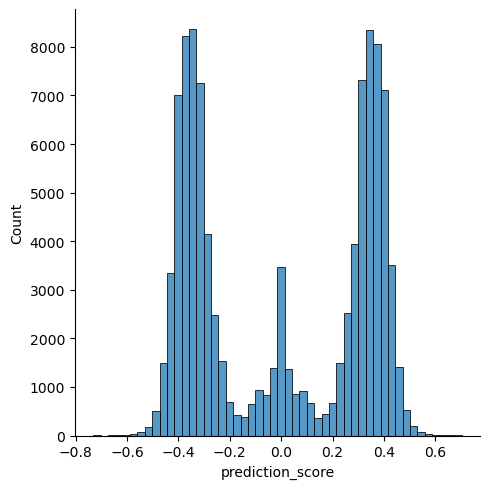

In [39]:
import seaborn as sns

sns.displot(nn_hist.prediction_score)


In [40]:
nn_hist[['prediction_score','result_score']].corr()


,prediction_score,result_score
prediction_score,1.00000,0.34145
result_score,0.34145,1.00000


In [41]:
nn_hist[['prediction_reb','result_reb','prediction_total','result_total','prediction_score','result_score']].corr()

,prediction_reb,result_reb,prediction_total,result_total,prediction_score,result_score
prediction_reb,1.000000,0.178319,-0.003061,-0.003940,0.971909,0.347992
result_reb,0.178319,1.000000,-0.002798,-0.005913,0.172700,0.536979
prediction_total,-0.003061,-0.002798,1.000000,0.023785,-0.005314,-0.003424
result_total,-0.003940,-0.005913,0.023785,1.000000,-0.003043,-0.001414
prediction_score,0.971909,0.172700,-0.005314,-0.003043,1.000000,0.341450
result_score,0.347992,0.536979,-0.003424,-0.001414,0.341450,1.000000


<Axes: xlabel='result_total', ylabel='Count'>

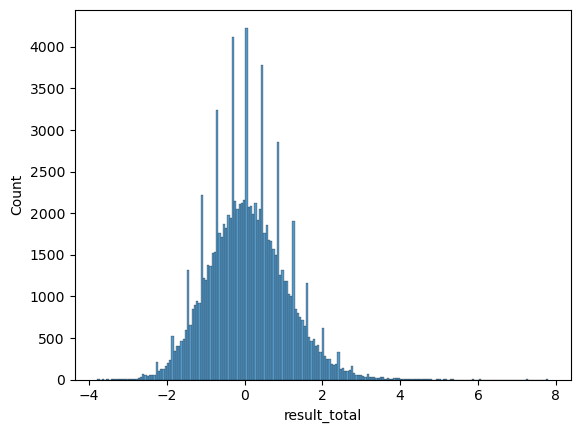

In [42]:
sns.histplot(nn_hist.result_total)

In [86]:
sns.histplot(nn_hist.prediction_total)


In [44]:

## doesn't actually keep last since single game per row
test = nn_hist.copy().drop_duplicates(subset=['p1_name'],keep='last')

test2 = test.copy()[['p1_name']]
test2['rtg_x'] = test2['p1_name'].copy().map(test.set_index('p1_name').to_dict()['p1_rating_x'])
test2['rtg_y'] = test2['p1_name'].copy().map(test.set_index('p1_name').to_dict()['p1_rating_y'])
test2['rtg_z'] = test2['p1_name'].copy().map(test.set_index('p1_name').to_dict()['p1_rating_z'])



In [64]:

color_data = data.groupby(['season','team_name'])['team_score'].mean().copy()[2022]
color_data = color_data/color_data.max()
color_data = color_data.to_dict()
test2['color'] = test2['p1_name'].copy().map(color_data)


In [80]:
import matplotlib.pyplot as plt


In [83]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(test2.rtg_x, test2.rtg_y, test2.rtg_z, c=test2.color)
x = test2['rtg_x'].copy().values
y = test2['rtg_y'].copy().values
z = test2['rtg_z'].copy().values
for i, name in enumerate(list(test2.p1_name.values)):
    if name in ['Gonzaga','Houston','Kansas','Baylor','Arizona','Kentucky','Texas Tech','Duke','Tennessee','Villanova']:
        ax.text(x[i], y[i], z[i], name)
    elif x[i]**2+y[i]**2+z[i]**2 > 34:
        ax.text(x[i], y[i], z[i], name)
        
plt.show()


In [84]:

test.sort_values(by='p1_rating_x').tail(50)



In [85]:
test2.sort_values(by='color').tail(50)

In [35]:
stats

['score_total',
 'game_poss',
 'reb_diff',
 'score_diff',
 'fgm_diff',
 'fga_diff',
 'fgm3_diff',
 'fga3_diff',
 'ftm_diff',
 'fta_diff',
 'or_diff',
 'dr_diff',
 'ast_diff',
 'to_diff',
 'stl_diff',
 'blk_diff',
 'pf_diff']

In [36]:
targets

['score_diff', 'reb_diff', 'score_total']